<a href="https://colab.research.google.com/github/ChihHsiangChien/3rd-ML100Days/blob/master/homework/Day_100_transfer_learning_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical

from keras import backend as K
from keras.models import Model

from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10


In [7]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
#參數
image_size = x_train.shape[1:3] #image size = (32,32)

batch_size = 64      # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10     # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30          # 訓練整個資料集共 30個循環

freeze_layers = 2    # 凍結網路層數

In [0]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
augment_generator = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)


In [26]:
#建立ResNet50 model
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(image_size[0],image_size[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)



/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



NameError: ignored

In [28]:

# 設定凍結與要進行訓練的網路層
model = Model(inputs=net.input, outputs=output_layer)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False
for layer in model.layers[freeze_layers:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 輸出整個網路結構
print(model.summary())



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________

In [29]:

# 訓練模型
history = model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))


#
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
781/781 [==============================] - 110s 141ms/step - loss: 3.1318 - acc: 0.1616 - val_loss: 2.1168 - val_acc: 0.2817
Epoch 2/30
781/781 [==============================] - 90s 116ms/step - loss: 2.0783 - acc: 0.2854 - val_loss: 1.7331 - val_acc: 0.4326
Epoch 3/30
781/781 [==============================] - 89s 114ms/step - loss: 1.7319 - acc: 0.4107 - val_loss: 1.4299 - val_acc: 0.5325
Epoch 4/30
781/781 [==============================] - 88s 113ms/step - loss: 1.4651 - acc: 0.5035 - val_loss: 1.2419 - val_acc: 0.5859
Epoch 5/30
781/781 [==============================] - 88s 112ms/step - loss: 1.2885 - acc: 0.5591 - val_loss: 1.1047 - val_acc: 0.6302
Epoch 6/30
781/781 [==============================] - 87s 112ms/step - loss: 1.1567 - acc: 0.6059 - val_loss: 1.0015 - val_acc: 0.6654
Epoch 7/30
781/781 [==============================] - 88s 112ms/step - loss: 1.0707 - acc: 0.

Test loss: 0.6377064134597779
Test accuracy: 0.8114


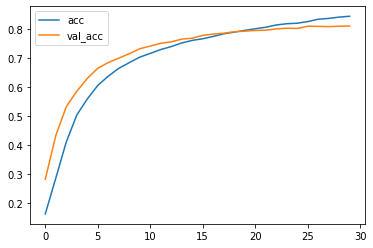

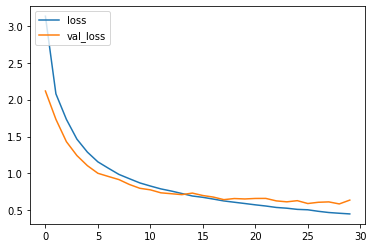

In [30]:
#印出結果
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(model.history.history['acc'],label='acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend(loc=2)
plt.show()
plt.plot(model.history.history['loss'],label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend(loc=2)
plt.show()